## this is the version i engineer the features of x

In [1]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool, TopKPooling
from torch_geometric.nn.glob import GlobalAttention
from torch_geometric.data import Data,DataLoader
# from torch.utils.data import DataLoader, TensorDataset
# from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip
from torch_geometric.utils import add_self_loops

from scipy import sparse

# load pickle module
import pickle
import networkx as nx
import torch.nn as nn

from tqdm import tqdm 

In [2]:
R0 = 2.5
rs = np.array([20, 10, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.025, 5.   ,  2.5  , 13.333,  3.333,  1.333,  0.667,  0.286,  0.133,
        0.067,  0.033,0.37,7.4])

In [3]:
rs.sort()

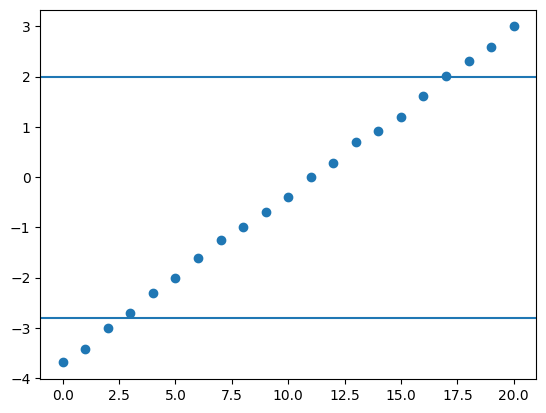

In [4]:
plt.scatter(range(21),np.log(rs))
plt.axhline(2)
plt.axhline(-2.8)

In [5]:
WN = np.loadtxt('../W_avg.csv') ### numpy arrary
WN2 = np.dot(WN, WN)
# prob = WN[:,1858]
prob = WN2[:,1858]
prob_2d = prob.reshape(-1,1)

In [6]:
g_s = nx.from_numpy_array(WN)
edges = np.array(g_s.edges()).transpose()
edge_index = torch.tensor(edges,dtype = torch.int64)
# edge_weight = torch.tensor(WN[edge_index[0], edge_index[1]], dtype=torch.float)
edge_weights = []
for (u, v) in g_s.edges():
    edge_weights.append([g_s[u][v]['weight']])
edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

In [7]:
def load_gzipped_numpy(filename):
    try:
        with gzip.open(filename, 'rb') as f:
            return np.load(f, allow_pickle=True)
    except FileNotFoundError:
        return [0]

In [36]:
r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3, 
           5.0:0 ,  2.5:1  , 13.333:0,  3.333:1,  1.333:1,  0.667:1,  0.286:2,  0.133:2,
        0.067:3,  0.033:3, 0.37:2,7.4:0}

In [9]:
export_dir = '/Users/qingyao/Documents/branching_data/simulation/python_cutoff_addno/'
#### data preparation
dataset = []

for r_idx in range(21):
    r = rs[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    r_c = r_class[r]
    print(r, r_c)
    # Create a list to hold our Data objects
    for g_idx in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(g_idx+1))
        g_i = load_gzipped_numpy(export_names)
#         g_i_new = np.hstack((g_i[:,10:], prob_2d))
        g_i_new = g_i[:,10:]
        
        matrix = torch.from_numpy(g_i_new)
        
        y = torch.log(torch.tensor([[r]], dtype=torch.float))
#         y = torch.tensor([[r]], dtype=torch.float)
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, edge_attr=edge_weights,y=y)
        data.x = data.x.float()
#         data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

0.025 3
0.033 3
0.05 3
0.067 3
0.1 2
0.133 2
0.2 2
0.286 2
0.37 2
0.5 1
0.667 1
1.0 1
1.333 1
2.0 1
2.5 1
3.333 1
5.0 0
7.4 0
10.0 0
13.333 0
20.0 0


In [10]:
# from torch.utils.data import random_split
# all_data_len = len(dataset)
# train_data, test_data = random_split(dataset, [int(all_data_len*0.8), int(all_data_len*0.2)])

#### validation_data is used to do the tunning the learning rate
#### need the std of test 


from torch.utils.data import random_split
all_data_len = len(dataset)


for e in range(10):    
    ### k folds cross validation
    train_data, test_data, validation_data = random_split(dataset, [int(all_data_len*0.6), int(all_data_len*0.2),  
                                               int(all_data_len*0.2)])
    ### I split one once and run the models on the same split for several times 
    for lr in np.arange(2^(-1), 2^(10)):
        for i in range(10): ### chose the right learning rate 
        ### i will have different models every time
        ### i use different learing rate for the same training set
    ### i use the best learing rate to apply on the test set



In [58]:
lr_list = [np.power(0.5,i) for i in range(1,11)]*10

In [ ]:
# def weighted_mse_loss(input, target, weight):
#     # Calculate MSE loss for each sample
#     individual_losses = F.mse_loss(input, target, reduction='none')
    
#     # Apply weights
#     weighted_losses = individual_losses * weight
    
#     # Average over all samples
#     loss = weighted_losses.mean()
#     return loss

In [ ]:
# def calculate_weights(targets, threshold_l,threshold_u):
#     # Assign a higher weight to targets above a certain threshold
#     weights = torch.ones_like(targets)
#     weights[targets > threshold_u] = 2  # e.g., 2, 3, 5, etc.
#     weights[targets < threshold_l] = 2
#     return weights

In [11]:
class GCN(torch.nn.Module): ### the simpliest model that GNN and it is classical, used as baseline
    def __init__(self, num_node_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 128)     
        self.conv2 = GCNConv(128, 64) 
        self.conv3 = GCNConv(64, 16) 
        self.conv4 = GCNConv(16, 8) 
        self.fc = torch.nn.Linear(8, 1)


    """
        hyperparameters:
        - number of hidden layers
        - number of hidden channels
        - dropout rate (now it's zero)
        - learning rate <- most important to tune
        - weight decay
        - etc etc.
    """

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
#         edge_index, edge_weight = add_self_loops(edge_index, edge_attr=edge_weight, num_nodes=x.size(0))

        x = self.conv1(x, edge_index, edge_weight)
#         x = F.leaky_relu(x)
        x = F.elu(x)

        x = self.conv2(x, edge_index, edge_weight)
#         x = F.leaky_relu(x)
        x = F.elu(x)

        x = self.conv3(x, edge_index, edge_weight)
#         x = F.leaky_relu(x)
        x = F.elu(x)
        
        x = self.conv4(x, edge_index, edge_weight)
#         x = F.leaky_relu(x)
        x = F.elu(x)

        x = global_mean_pool(x, batch)
        x = self.fc(x)

        return x

# Now we can create a DataLoader
myloader = DataLoader(train_data, batch_size=128, shuffle=True)
# Create a model and an optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_node_features=50).to(device) ### only look at the last 30 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

def train(model, optimizer, loader):
    model.train()
    loss_all = 0
    correct = 0
    y_true = []
    total = 0
    results = []
    for data in myloader:
        data = data.to(device)
        optimizer.zero_grad() 
        output = model(data) 
        label = data.y.to(device)
        y_true.append(label)
        
        # Calculate weights based on extremes
#         weights = calculate_weights(label, -2.8,2)
        # Use the custom weighted loss function
#         loss = weighted_mse_loss(output, label, weights)
        loss = F.mse_loss(output, label) 
#         loss = F.cross_entropy(output, label)
        loss.backward() 
        loss_all += data.num_graphs * loss.item()
        
        optimizer.step() 
        results.append(output)
    
    return loss_all / len(myloader.dataset), results, y_true



counter = 0
count_epochs = 0
best = float("inf")
epochs = 100
patience = 10
loss_ep= []
 
for epoch in (pbar := tqdm(range(1, epochs + 1))):
    loss, myres, reals = train(model, optimizer, myloader)
    loss_ep.append(loss)
#     ac_ep.append(ac)
    print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch, loss))
    if loss < best:
        best = loss
        counter = 0
    else:
        counter += 1
        count_epochs += 1
        
    if counter > patience:
        break
        # print(f"Epoch: {​​​​​​epoch:03d}​​​​​​, Loss: {​​​​​​loss:.4f}​​​​​​")
#     scheduler.step()
    pbar.set_description(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")
print("\n", "Stopped early at epoch: ", count_epochs)


/Users/qingyao/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Epoch: 001, Loss: 5.9513:   1%|▏              | 1/100 [00:51<1:25:15, 51.67s/it]

Epoch: 001, Loss: 5.95130


Epoch: 002, Loss: 4.2097:   2%|▎              | 2/100 [01:44<1:25:10, 52.15s/it]

Epoch: 002, Loss: 4.20969


Epoch: 003, Loss: 2.9637:   3%|▍              | 3/100 [02:34<1:23:19, 51.54s/it]

Epoch: 003, Loss: 2.96373


Epoch: 004, Loss: 1.7656:   4%|▌              | 4/100 [03:25<1:21:59, 51.25s/it]

Epoch: 004, Loss: 1.76564


Epoch: 005, Loss: 1.4586:   5%|▊              | 5/100 [04:17<1:21:15, 51.32s/it]

Epoch: 005, Loss: 1.45856


Epoch: 006, Loss: 1.7061:   6%|▉              | 6/100 [05:09<1:21:01, 51.72s/it]

Epoch: 006, Loss: 1.70611


Epoch: 007, Loss: 1.5648:   7%|█              | 7/100 [06:02<1:20:49, 52.15s/it]

Epoch: 007, Loss: 1.56476


Epoch: 008, Loss: 1.1061:   8%|█▏             | 8/100 [06:54<1:19:54, 52.11s/it]

Epoch: 008, Loss: 1.10608


Epoch: 009, Loss: 0.9711:   9%|█▎             | 9/100 [07:47<1:19:07, 52.17s/it]

Epoch: 009, Loss: 0.97112


Epoch: 010, Loss: 0.9407:  10%|█▍            | 10/100 [08:38<1:18:06, 52.07s/it]

Epoch: 010, Loss: 0.94065


Epoch: 011, Loss: 0.8863:  11%|█▌            | 11/100 [09:31<1:17:19, 52.13s/it]

Epoch: 011, Loss: 0.88634


Epoch: 012, Loss: 0.8557:  12%|█▋            | 12/100 [10:23<1:16:30, 52.17s/it]

Epoch: 012, Loss: 0.85573


Epoch: 013, Loss: 0.9670:  13%|█▊            | 13/100 [11:15<1:15:36, 52.14s/it]

Epoch: 013, Loss: 0.96699


Epoch: 014, Loss: 0.8009:  14%|█▉            | 14/100 [12:07<1:14:32, 52.00s/it]

Epoch: 014, Loss: 0.80091


Epoch: 015, Loss: 0.7541:  15%|██            | 15/100 [12:56<1:12:36, 51.25s/it]

Epoch: 015, Loss: 0.75407


Epoch: 016, Loss: 0.7041:  16%|██▏           | 16/100 [13:48<1:11:59, 51.43s/it]

Epoch: 016, Loss: 0.70408


Epoch: 017, Loss: 0.7230:  17%|██▍           | 17/100 [14:39<1:10:45, 51.15s/it]

Epoch: 017, Loss: 0.72302


Epoch: 018, Loss: 0.6890:  18%|██▌           | 18/100 [15:29<1:09:45, 51.04s/it]

Epoch: 018, Loss: 0.68895


Epoch: 019, Loss: 0.6645:  19%|██▋           | 19/100 [16:20<1:08:49, 50.99s/it]

Epoch: 019, Loss: 0.66454


Epoch: 020, Loss: 0.6671:  20%|██▊           | 20/100 [17:11<1:07:53, 50.92s/it]

Epoch: 020, Loss: 0.66705


Epoch: 021, Loss: 0.6621:  21%|██▉           | 21/100 [18:02<1:07:09, 51.01s/it]

Epoch: 021, Loss: 0.66208


Epoch: 022, Loss: 0.6053:  22%|███           | 22/100 [18:55<1:06:49, 51.41s/it]

Epoch: 022, Loss: 0.60532


Epoch: 023, Loss: 0.5802:  23%|███▏          | 23/100 [19:47<1:06:25, 51.76s/it]

Epoch: 023, Loss: 0.58024


Epoch: 024, Loss: 0.5542:  24%|███▎          | 24/100 [20:39<1:05:34, 51.77s/it]

Epoch: 024, Loss: 0.55418


Epoch: 025, Loss: 0.5396:  25%|███▌          | 25/100 [21:32<1:05:18, 52.24s/it]

Epoch: 025, Loss: 0.53957


Epoch: 026, Loss: 0.5249:  26%|███▋          | 26/100 [22:24<1:04:16, 52.11s/it]

Epoch: 026, Loss: 0.52488


Epoch: 027, Loss: 0.6521:  27%|███▊          | 27/100 [23:15<1:02:56, 51.74s/it]

Epoch: 027, Loss: 0.65212


Epoch: 028, Loss: 0.5694:  28%|███▉          | 28/100 [24:06<1:01:52, 51.56s/it]

Epoch: 028, Loss: 0.56938


Epoch: 029, Loss: 0.5046:  29%|████          | 29/100 [24:57<1:00:38, 51.25s/it]

Epoch: 029, Loss: 0.50459


Epoch: 030, Loss: 0.5008:  30%|████▊           | 30/100 [25:48<59:49, 51.28s/it]

Epoch: 030, Loss: 0.50084


Epoch: 031, Loss: 1.2026:  31%|████▉           | 31/100 [26:40<59:13, 51.49s/it]

Epoch: 031, Loss: 1.20263


Epoch: 032, Loss: 0.9968:  32%|█████           | 32/100 [27:32<58:43, 51.82s/it]

Epoch: 032, Loss: 0.99679


Epoch: 033, Loss: 1.6887:  33%|█████▎          | 33/100 [28:25<58:00, 51.94s/it]

Epoch: 033, Loss: 1.68870


Epoch: 034, Loss: 0.8045:  34%|█████▍          | 34/100 [29:17<57:20, 52.13s/it]

Epoch: 034, Loss: 0.80446


Epoch: 035, Loss: 0.6677:  35%|█████▌          | 35/100 [30:09<56:20, 52.00s/it]

Epoch: 035, Loss: 0.66775


Epoch: 036, Loss: 0.8152:  36%|█████▊          | 36/100 [31:01<55:26, 51.98s/it]

Epoch: 036, Loss: 0.81519


Epoch: 037, Loss: 0.6470:  37%|█████▉          | 37/100 [31:53<54:45, 52.15s/it]

Epoch: 037, Loss: 0.64695


Epoch: 038, Loss: 0.5787:  38%|██████          | 38/100 [32:45<53:46, 52.03s/it]

Epoch: 038, Loss: 0.57874


Epoch: 039, Loss: 0.5447:  39%|██████▏         | 39/100 [33:37<52:45, 51.89s/it]

Epoch: 039, Loss: 0.54466


Epoch: 040, Loss: 0.5241:  40%|██████▍         | 40/100 [34:29<51:56, 51.95s/it]

Epoch: 040, Loss: 0.52413


Epoch: 040, Loss: 0.5241:  40%|██████▍         | 40/100 [35:12<52:48, 52.81s/it]

Epoch: 041, Loss: 0.52183

 Stopped early at epoch:  18


In [63]:
np.array

0.5218273161895691

In [ ]:
## remove the edge index to see if the graph is helping
## remove the conv layers, relu--> linear regression works
## r values which have never see before 

In [12]:
import scipy.stats as stats
def bootstrap_median_confidence_interval(data, ci=95, n_bootstraps=10000):
    bootstrapped_medians = []
    n = len(data)

    for _ in range(n_bootstraps):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrapped_medians.append(np.median(sample))

    lower_bound = np.percentile(bootstrapped_medians, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrapped_medians, 100 - (100 - ci) / 2)
    medians = np.percentile(bootstrapped_medians, 50)

    return medians, lower_bound, upper_bound

In [13]:
ci = 95

In [14]:
100 - (100 - ci) / 2

97.5

In [15]:
len(myres)

40

In [16]:
training_y = []
training_true = []
for t_s in range(40):
    training_y.extend(list(myres[t_s].detach().ravel().numpy()))
    training_true.extend(list(reals[t_s].detach().ravel().numpy()))

In [17]:
training = {}
for p, t in zip(training_y, training_true):
    real_r = np.round(np.exp(t),3)
    if real_r in training.keys():
        training[real_r].append(p)
    else:
        training[real_r] = [p]

In [18]:
len(training.keys())

21

In [19]:
Bootstrap_ci = []
Bootstrap_mean = []
for r_idx in range(21):
    r = rs[r_idx]
    r = np.float32(r)
    print(r)
    data = np.exp(training[r])
#     data = training[r]
#     k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95)
    Bootstrap_ci.append([l_b, u_b])
    Bootstrap_mean.append(sample_median)

0.025
0.033
0.05
0.067
0.1
0.133
0.2
0.286
0.37
0.5
0.667
1.0
1.333
2.0
2.5
3.333
5.0
7.4
10.0
13.333
20.0


In [20]:
CI = np.array(Bootstrap_ci)

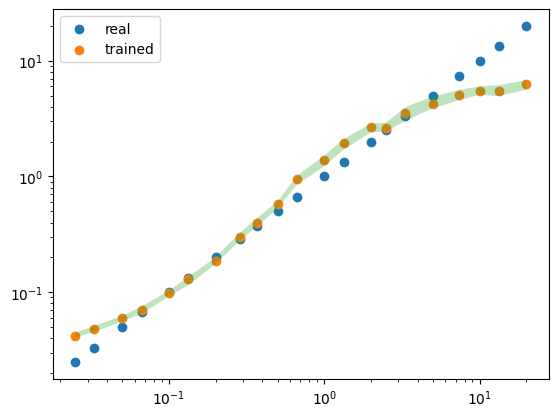

In [21]:
plt.scatter(rs,rs,label='real')
plt.scatter(rs,np.array(Bootstrap_mean),label='trained')
plt.fill_between(rs,CI[:,1],CI[:,0],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.legend()
# plt.savefig('regression.png')

In [22]:
def test():
    model.eval()
    predictions = []
    total_loss = 0
    true_values = []
    with torch.no_grad():
        for data in testloader:
            data = data.to(device)
            output = model(data)
            loss = F.mse_loss(output, data.y)
            total_loss += loss.item() * data.num_graphs
            predictions.append(output.cpu())
            true_values.append(data.y.cpu())
    return torch.cat(predictions, dim=0), torch.cat(true_values, dim=0),total_loss / len(testloader.dataset)

In [23]:
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [62]:
predictions, y_true, test_mse  = test()
print(f"Test MSE: {test_mse:.4f}")
# print(predictions)

Test MSE: 11.0467


In [61]:
test_mse

11.046705106099447

In [25]:
results = {}
for p, t in zip(predictions.ravel().numpy(), y_true.ravel().numpy()):
    real_r = np.round(np.exp(t),3)
    if real_r in results.keys():
        results[real_r].append(p)
    else:
        results[real_r] = [p]

In [ ]:
import pickle

# Assuming 'results' is your dictionary
with open('gnn_regression.pkl', 'wb') as file:
    pickle.dump(results, file)

In [26]:
Bootstrap_ci = []
Bootstrap_mean = []
per_95 = []
per_5 = []
for r_idx in range(21):
    r = rs[r_idx]
    r = np.float32(r)
    print(r)
    data = np.exp(results[r])
#     data = training[r]
#     k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95,n_bootstraps=100)
    Bootstrap_ci.append([l_b, u_b])
    Bootstrap_mean.append(sample_median)
    per_95.append(np.percentile(data,95))
    per_5.append(np.percentile(data,5))

0.025
0.033
0.05
0.067
0.1
0.133
0.2
0.286
0.37
0.5
0.667
1.0
1.333
2.0
2.5
3.333
5.0
7.4
10.0
13.333
20.0


In [27]:
CI = np.array(Bootstrap_ci)

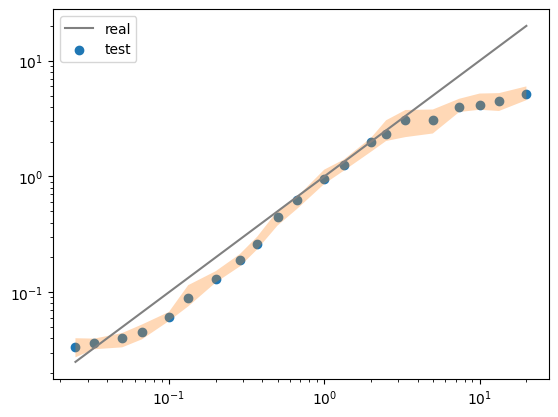

In [28]:
plt.plot(rs,rs,label='real',c='grey')
plt.scatter(rs,np.array(Bootstrap_mean),label='test')
plt.fill_between(rs,CI[:,1],CI[:,0],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [29]:
rs = rs[::-1]

51
52
61
62
55
61
59
51
53
76
67
62
58
59
74
59
59
60
57
66
58


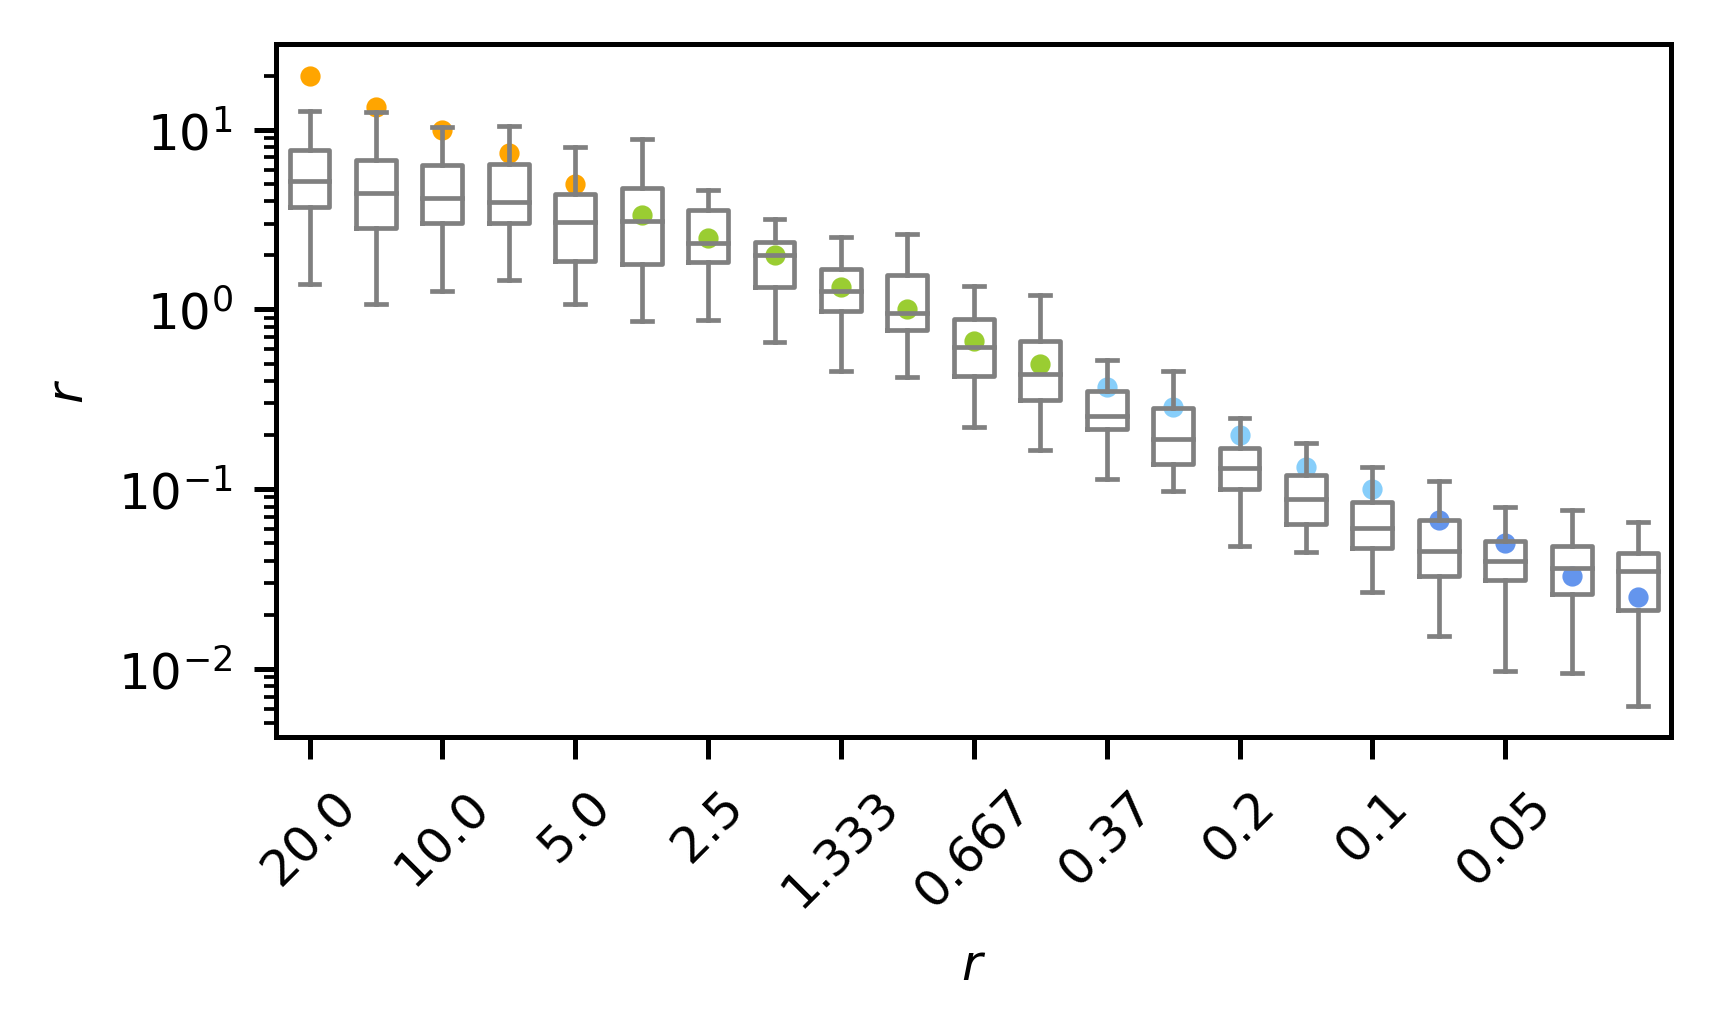

In [32]:
fig, ax = plt.subplots(figsize=(4,2.),dpi=450)
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}

line_properties = dict(linestyle='-', linewidth=0.75, color='gray')


for r_idx in range(21):
    r = rs[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    # Plot each boxplot at position k_idx + 1
#     y = np.exp()
#     ax.boxplot(results[k], positions=[k_idx + 1])
    real_pr = np.exp(results[r])
    std = np.std(real_pr)
    
    ax.boxplot(real_pr, positions=[r_idx+1],showfliers=False,
               boxprops = dict(linestyle='-', linewidth=0.75, color='gray'),
               whiskerprops=line_properties, widths=0.6,
           capprops=line_properties,
              medianprops=dict(linestyle='-', linewidth=0.75, color='gray'))
    
    myc = colors[c]
    # Plot the scatter point at the same position
    ax.scatter(r_idx + 1, r, color=myc, s=5)

    print(len(results[r]))

# Show the plot after adding all boxplots
ax.set_xticks(np.array([0,2,4,6,8,10,12,14,16,18])+1)  # Setting x-ticks positions
ax.set_xticklabels(rs[[0,2,4,6,8,10,12,14,16,18]])  # Assuming 'rs' is your array of labels
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(-5,4)
plt.xticks(rotation=45)
plt.xlabel('$r$',size=8)
plt.ylabel('$r$',size=8)
ax.tick_params(axis='both', labelsize=8)
# plt.show()
# plt.savefig("gnn_regression.pdf", bbox_inches='tight', pad_inches=0)

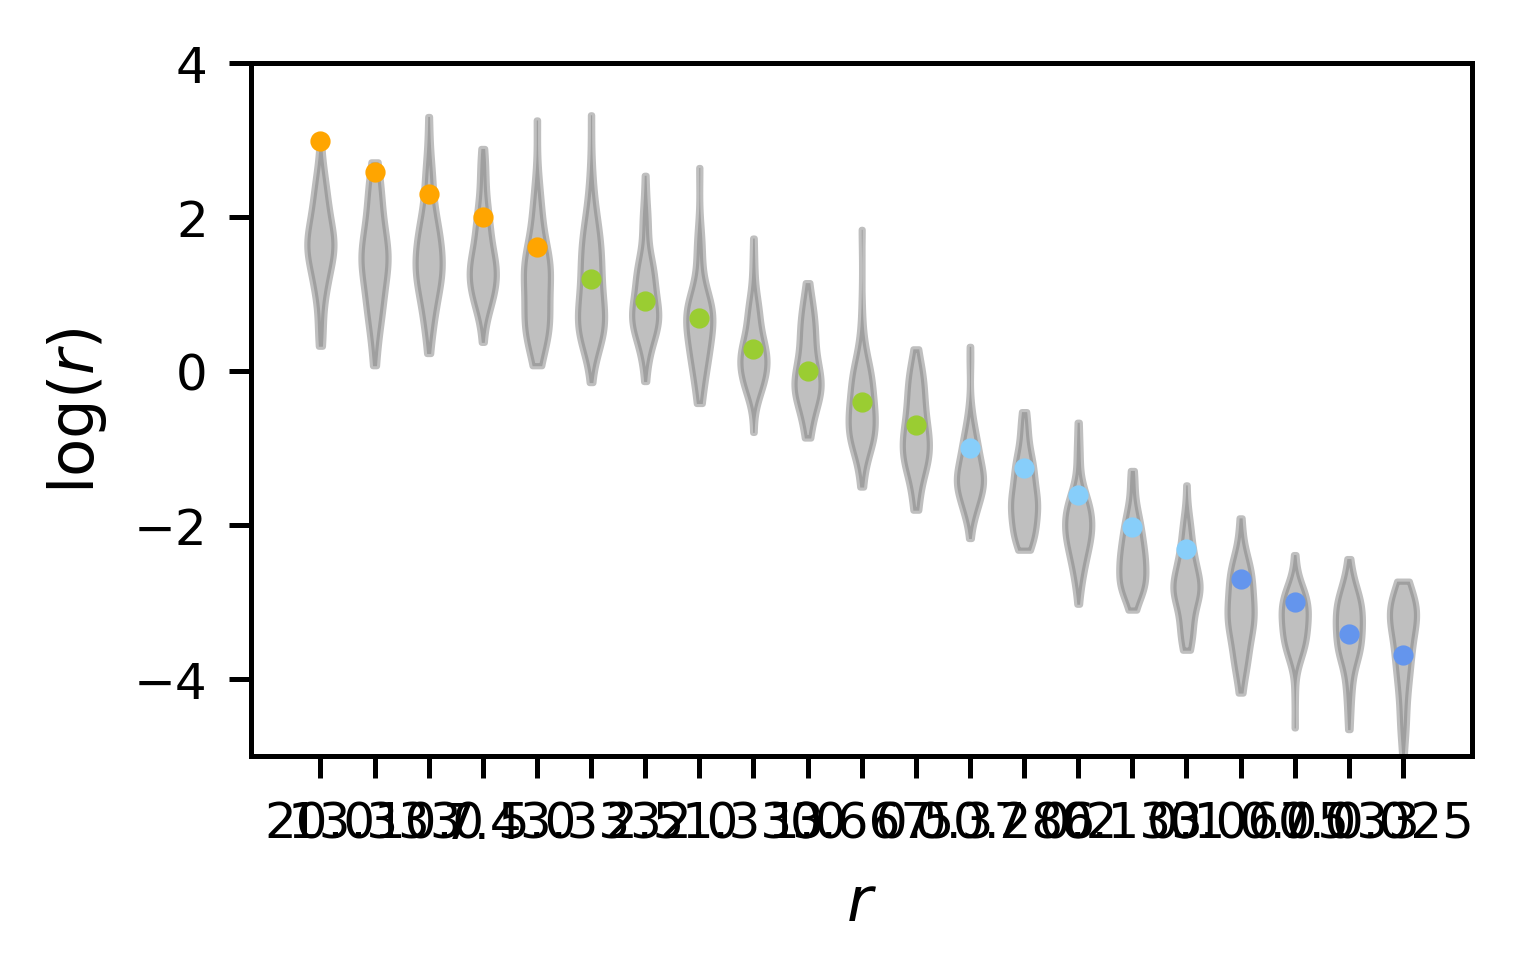

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'results' and 'rs' are defined as before

fig, ax = plt.subplots(figsize=(3.5,2), dpi=450)

colors = {0:'orange', 1:'yellowgreen', 2:'lightskyblue', 3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}

for r_idx in range(21):
    r = rs[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    
    # Creating the violin plot at position r_idx + 1
    vp = ax.violinplot(results[r], positions=[r_idx + 1], showmeans=False, showmedians=False, showextrema=False)
    
    # You can set the color of each part of the violin plot
    for pc in vp['bodies']:
        pc.set_facecolor('grey')
        pc.set_edgecolor('grey')
        pc.set_alpha(0.5)

    # Plot the scatter point at the same position
    ax.scatter(r_idx + 1, k, color=colors[c], s=5)

# Setting x-ticks positions and labels
ax.set_xticks(range(1, 22))
ax.set_xticklabels(rs)

# Setting the limits for y-axis and font size for ticks
plt.ylim(-5, 4)
plt.xlabel('$r$')
plt.ylabel('$\log(r)$')
ax.tick_params(axis='both', labelsize=8)

plt.show()


In [34]:
rs = rs[::-1]

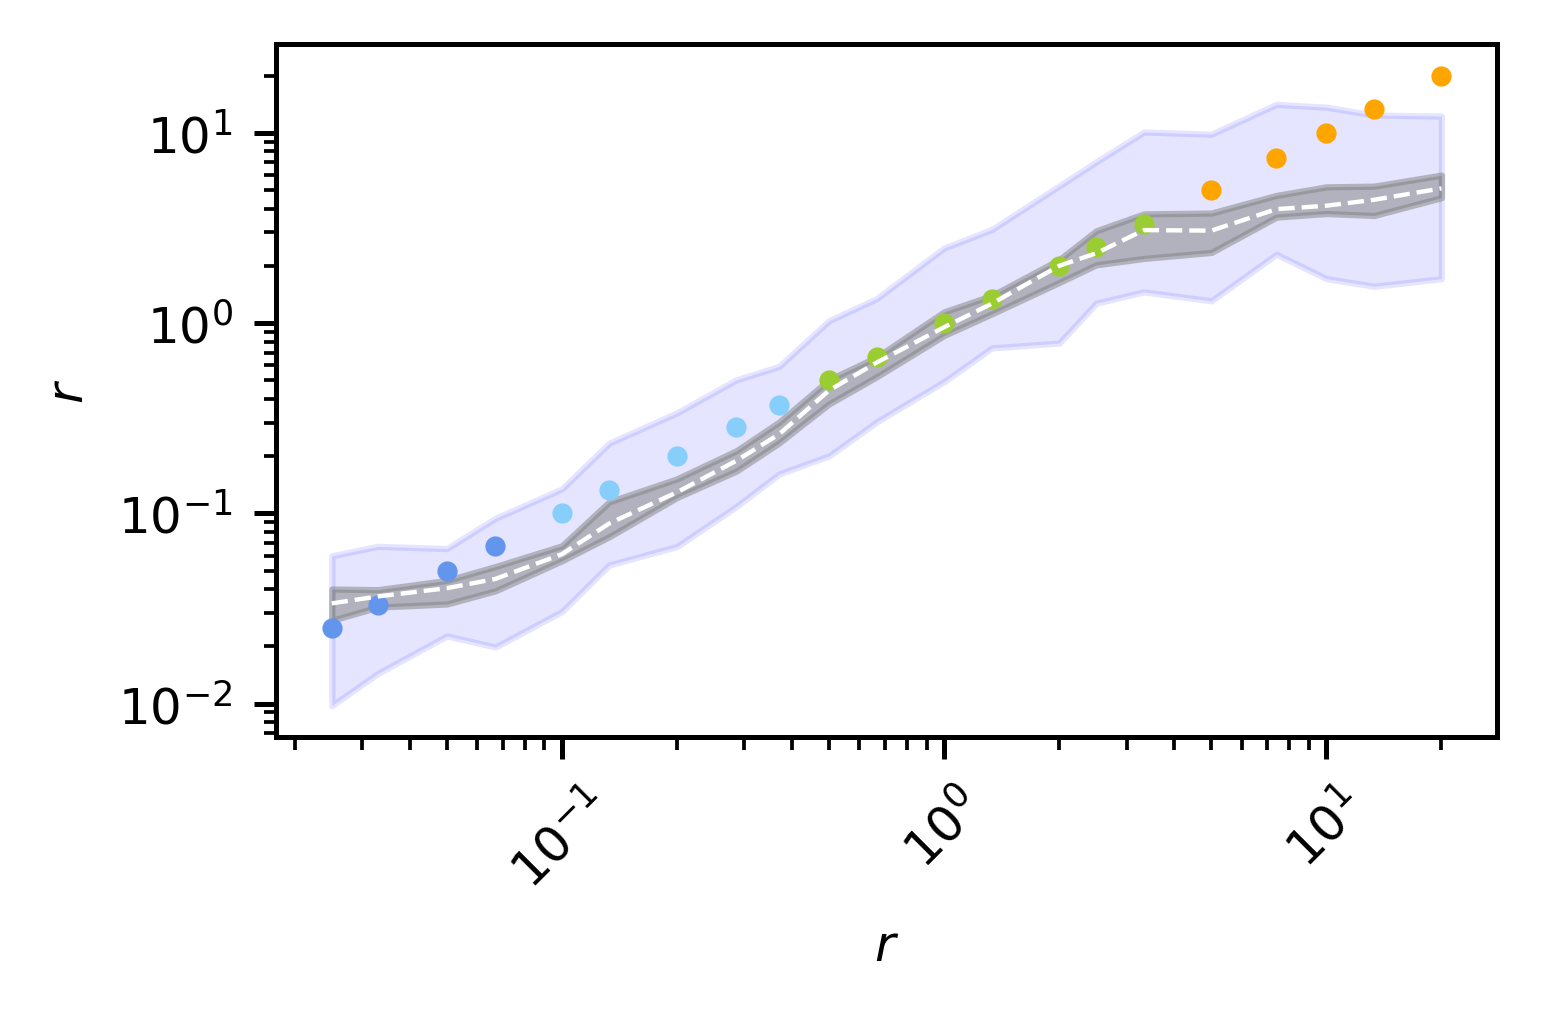

In [37]:
fig, ax = plt.subplots(figsize=(3.5,2),dpi=450)
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}

line_properties = dict(linestyle='-', linewidth=0.75, color='gray')

# plt.plot(rs,rs,label='real',c='grey')
plt.plot(rs,np.array(Bootstrap_mean),ls='--',lw=0.7,color='white')

plt.fill_between(rs, np.array(per_5),np.array(per_95),
                 alpha=0.1,color='blue')
plt.fill_between(rs,CI[:,1],CI[:,0],alpha=0.5,color='grey')

for r_idx in range(21):
    r = rs[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    # Plot each boxplot at position k_idx + 1
#     y = np.exp()
#     ax.boxplot(results[k], positions=[k_idx + 1])
#     real_pr = np.exp(results[r])
#     std_list.append(np.std(real_pr))
#     median_list.append(np.median(real_pr))

    
#     ax.boxplot(real_pr, positions=[r_idx+1],showfliers=False,
#                boxprops = dict(linestyle='-', linewidth=0.75, color='gray'),
#                whiskerprops=line_properties, widths=0.4,
#            capprops=line_properties,
#               medianprops=dict(linestyle='-', linewidth=1, color='gray'))
    
    myc = colors[c]
    # Plot the scatter point at the same position
    ax.scatter(r, r, color=myc, s=5)

#     print(len(results[r]))
# plt.plot(rs, median_list,ls='--',lw=0.7)

# Show the plot after adding all boxplots
# label_pos = np.array([0,2,4,6,8,10,12,15,16,18])+1
# ax.set_xticks(label_pos)  # Setting x-ticks positions
# ax.set_xticklabels(rs[[0,2,4,6,8,10,12,15,16,18]])  # Assuming 'rs' is your array of labels
plt.xticks(rotation=45)
plt.yscale('log')
plt.xscale('log')
# plt.ylim(-5,4)
plt.xlabel('$r$',size=8)
plt.ylabel('$r$',size=8)
ax.tick_params(axis='both', labelsize=8)
# plt.show()
# plt.savefig("gnn_regression.pdf", bbox_inches='tight', pad_inches=0)

In [38]:
rs_add = np.array([12.5 ,  4.  ,  0.4 ,  0.08])

In [39]:
export_dir = '/Users/qingyao/Documents/branching_data/simulation/unseen/'
#### data preparation
dataset = []
r_class = {12.5:0 ,  4.:1  ,  0.4:2 ,  0.08:3}
for r_idx in range(4):
    r = rs_add[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    r_c = r_class[r]
    print(r, r_c)
    # Create a list to hold our Data objects
    for g_idx in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(g_idx+1))
        g_i = load_gzipped_numpy(export_names)
#         g_i_new = np.hstack((g_i[:,10:], prob_2d))
        g_i_new = g_i[:,10:] * prob_2d
        
        matrix = torch.from_numpy(g_i_new)
        
        y = torch.log(torch.tensor([[r]], dtype=torch.float))
#         y = torch.tensor([[r]], dtype=torch.float)
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, edge_attr=edge_weights,y=y)
        data.x = data.x.float()
#         data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

12.5 0
4.0 1
0.4 2
0.08 3


In [47]:
testloader = DataLoader(dataset, batch_size=128, shuffle=True)

/Users/qingyao/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [48]:
predictions, y_true, test_mse  = test()
print(f"Test MSE: {test_mse:.4f}")
# print(predictions)

Test MSE: 11.0467


In [49]:
results = {}
for p, t in zip(predictions.ravel().numpy(), y_true.ravel().numpy()):
    real_r = np.round(np.exp(t),3)
    if real_r in results.keys():
        results[real_r].append(p)
    else:
        results[real_r] = [p]

In [50]:
Bootstrap_ci = []
Bootstrap_mean = []
per_95 = []
per_5 = []
for r_idx in range(4):
    r = rs_add[r_idx]
    r = np.float32(r)
    print(r)
    data = np.exp(results[r])
#     data = training[r]
#     k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95,n_bootstraps=100)
    Bootstrap_ci.append([l_b, u_b])
    Bootstrap_mean.append(sample_median)
    per_95.append(np.percentile(data,95))
    per_5.append(np.percentile(data,5))

12.5
4.0
0.4
0.08


In [44]:
CI = np.array(Bootstrap_ci)

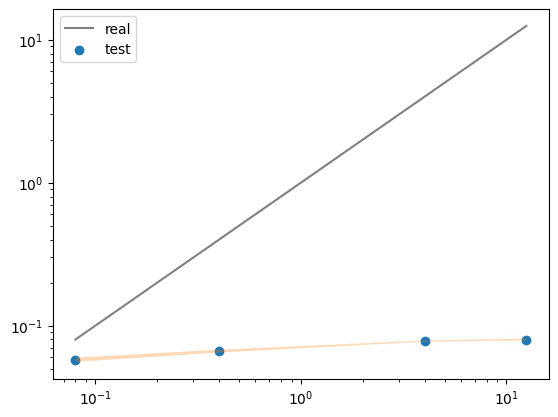

In [45]:
plt.plot(rs_add,rs_add,label='real',c='grey')
plt.scatter(rs_add,np.array(Bootstrap_mean),label='test')
plt.fill_between(rs_add,CI[:,1],CI[:,0],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.legend()

300
300
300
300


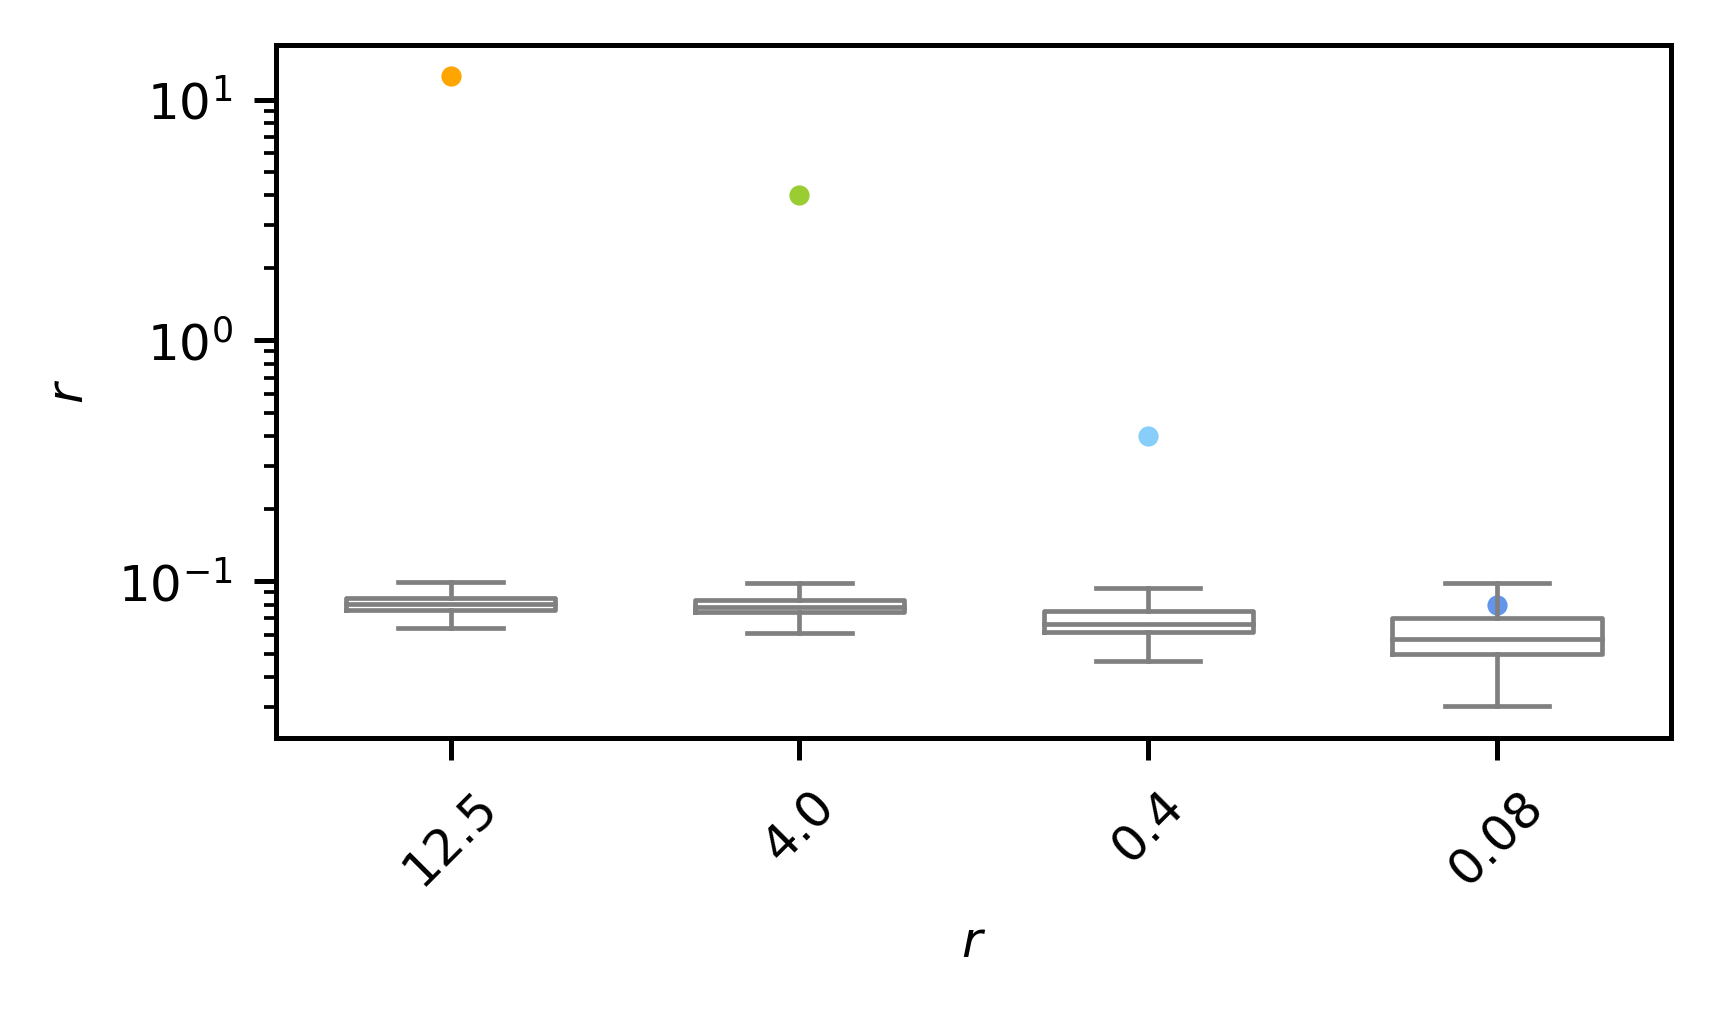

In [46]:
fig, ax = plt.subplots(figsize=(4,2.),dpi=450)
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3, 
#            5.0:0 ,  2.5:1  , 13.333:0,  3.333:1,  1.333:1,  0.667:1,  0.286:2,  0.133:2,
#         0.067:3,  0.033:3}
line_properties = dict(linestyle='-', linewidth=0.75, color='gray')


for r_idx in range(4):
    r = rs_add[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    # Plot each boxplot at position k_idx + 1
#     y = np.exp()
#     ax.boxplot(results[k], positions=[k_idx + 1])
    real_pr = np.exp(results[r])
    std = np.std(real_pr)
    
    ax.boxplot(real_pr, positions=[r_idx+1],showfliers=False,
               boxprops = dict(linestyle='-', linewidth=0.75, color='gray'),
               whiskerprops=line_properties, widths=0.6,
           capprops=line_properties,
              medianprops=dict(linestyle='-', linewidth=0.75, color='gray'))
    
    myc = colors[c]
    # Plot the scatter point at the same position
    ax.scatter(r_idx + 1, r, color=myc, s=5)

    print(len(results[r]))

# Show the plot after adding all boxplots
ax.set_xticks(np.array([0,1,2,3])+1)  # Setting x-ticks positions
ax.set_xticklabels(rs_add)  # Assuming 'rs' is your array of labels
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(-5,4)
plt.xticks(rotation=45)
plt.xlabel('$r$',size=8)
plt.ylabel('$r$',size=8)
ax.tick_params(axis='both', labelsize=8)